In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from collections import deque
import bisect

### Part 1: Data Preprocessing and Cleaning:

In [4]:
class CSVreader: 
    def __init__ (self):
        self.data = None 
    
    def open(self, file_name):              #opens the csv file 
        self.data = pd.read_csv(file_name, encoding='ISO-8859-1') 
        print('Data loaded successfully') 
        
    def head(self):                         #preview the csv file 
        return self.data.head() 
        
    def type (self):                        #check data type for each column 
        return self.data.dtypes

    def missing_values(self):               #list any missing values  
        x = self.data.isnull().sum().sum()
        print(f'There are {x} missing values in the file: ')
        return self.data.isnull().sum()

    def NA_replace (self, replacement_value = 'N/A'): #for missing value in file, replace with 'N/A'   
        for column in self.data.columns:
             self.data[column] = self.data[column].fillna(replacement_value)
        print("Missing values have been replaced with N/A")
             
    def dateFormat (self):                    #change format to datetime dd-mm-yyy
        self.data['order_date'] = pd.to_datetime(self.data['order_date'], format='%d-%m-%Y')
        self.data['ship_date'] = pd.to_datetime(self.data['ship_date'], format='%d-%m-%Y')
        print("Successfully updated 'order_date' and 'ship_date' to datetime format: dd-mm-yyy") 

    def float (self, column_id):              #change sales to corret float format 
        self.data[column_id] = self.data[column_id].replace(',', '', regex=True).astype(float)
        print(f'Succesfully updated "{column_id}" to float format')

    def sales_summary(self):                 #provide a summary statistics of sales data
        return self.data.describe()
    
    def int (self, column_id):                #change to integer format 
        self.data[column_id] = self.data[column_id].astype(int)
        print(f'Succesfully updated "{column_id}" to integer format')

    def outliers (self, column_id, threshold):  #show outliers 
        z = np.abs(stats.zscore(self.data[column_id]))
        outliers = self.data [z > threshold]
        print(f'There are {len(outliers)} outliers in "{column_id}"')   
        print(outliers.head())

    def replace_outliers (self, column_id, threshold): #replace outliers with the median value of specified column 
        z = np.abs(stats.zscore(self.data[column_id]))
        outliers = self.data [z > threshold]
        median = self.data[column_id].median()
        self.data.loc[z > threshold, column_id] = median

        print(f'{len(outliers)} outliers in "{column_id}" have been replaced with median value: "{median}"')

    def copy (self): #copies the cleaned up dataframe for further analysis 
        return self.data.copy()

In [5]:
# We will run the following code in order for data cleaning 
df = CSVreader()
df.open("SuperStore_Orders.csv")
df.NA_replace ()
df.dateFormat()
df.float('sales')
df.int('sales')
df.int('quantity')        
df.replace_outliers('sales', 3)
df.type()

Data loaded successfully
Missing values have been replaced with N/A
Successfully updated 'order_date' and 'ship_date' to datetime format: dd-mm-yyy
Succesfully updated "sales" to float format
Succesfully updated "sales" to integer format
Succesfully updated "quantity" to integer format
1019 outliers in "sales" have been replaced with median value: "85.0"


order_id                  object
order_date        datetime64[ns]
ship_date         datetime64[ns]
ship_mode                 object
customer_name             object
segment                   object
state                     object
country                   object
market                    object
region                    object
product_id                object
category                  object
sub_category              object
product_name              object
sales                      int64
quantity                   int64
discount                 float64
profit                   float64
shipping_cost            float64
order_priority            object
year                       int64
dtype: object

### Part 2: Data Analysis & Efficiency Considerations:

In [7]:
#we will create a copy of our cleaned dataframe for further analysis
df = df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   order_id        51290 non-null  object        
 1   order_date      51290 non-null  datetime64[ns]
 2   ship_date       51290 non-null  datetime64[ns]
 3   ship_mode       51290 non-null  object        
 4   customer_name   51290 non-null  object        
 5   segment         51290 non-null  object        
 6   state           51290 non-null  object        
 7   country         51290 non-null  object        
 8   market          51290 non-null  object        
 9   region          51290 non-null  object        
 10  product_id      51290 non-null  object        
 11  category        51290 non-null  object        
 12  sub_category    51290 non-null  object        
 13  product_name    51290 non-null  object        
 14  sales           51290 non-null  int64         
 15  qu

#### Implement an algorithm to identify the top 10 sub-categories by sales.

In [5]:
# Selecting only the 'sub_category' and 'sales' columns
top_10_subcat = df.groupby('sub_category')['sales'].sum().sort_values(ascending=False).head(10)
top_10_subcat = top_10_subcat.reset_index()

# We will add a 'thousand' column to make it easier to read 
top_10_subcat['sales K'] = ['$ '+str(round(int(v)/1000))+' K' for v in top_10_subcat.sales]

#show table
top_10_subcat

,sub_category,sales,sales K
0,Chairs,1203326,$ 1203 K
1,Copiers,1168090,$ 1168 K
2,Phones,1152359,$ 1152 K
3,Bookcases,1124172,$ 1124 K
4,Storage,1086645,$ 1087 K
5,Accessories,685050,$ 685 K
6,Appliances,605452,$ 605 K
7,Machines,570672,$ 571 K
8,Tables,477967,$ 478 K
9,Furnishings,385609,$ 386 K


#### Design a datastructure to store the monthly sales trend for the entire superstore

In [6]:
# Extract only month and year from the 'Order Date' column
df['Year-Month'] = df['order_date'].dt.to_period('M')

# Group by 'YearMonth' and sum up the 'Sales' for each month
monthly_sales = df.groupby('Year-Month')['sales'].sum().reset_index().sort_values(by='Year-Month', ascending=True)
monthly_sales['sales K'] = ['$ '+str(round(int(v)/1000))+' K' for v in monthly_sales.sales]

#display monthly sales trend for first 10 months
monthly_sales.head(10)

,Year-Month,sales,sales K
0,2011-01,79166,$ 79 K
1,2011-02,71448,$ 71 K
2,2011-03,102237,$ 102 K
3,2011-04,98348,$ 98 K
4,2011-05,119254,$ 119 K
5,2011-06,177508,$ 178 K
6,2011-07,97633,$ 98 K
7,2011-08,161436,$ 161 K
8,2011-09,207219,$ 207 K
9,2011-10,166167,$ 166 K


#### Implement a search algorithm to find all days where a promo led to sales above a certain threshold.

In [7]:
#copy the df where there was a promo applpied
df_promo = df[df.discount != 0]

#declare threshold value, and days list
threshold = 100
days = []

for i, row in df_promo.iterrows():
    if row.sales > threshold: 
        days.append(row.order_date) #add day to list 

unique_days = set(days)
unique_days_count = len(set(days))

print(f'There were {unique_days_count} days where a promo led to sale above ${threshold}')
#print(set(days))

There were 1309 days where a promo led to sale above $100


#### Design a scenario where a Stack or Queue data structure would be helpful in processing or analyzing the dataset. Implement this scenario and explain your choice.

The Stack Data Structure was implemented.
The use of a stack in this scenario provides an efficient way to manage the 2 models. 
The Stack scenario allows the researcher to switch between models and easily track their predictive power. 
The deque is particularly suited for this task because it provides fast O(1) appends and pops, 
making it efficient for stack operations

In [12]:


#Defining the train_and_predict function:
#It fits the model on the training data and returns predictions on the test data.
def train_and_predict(model, X_train, y_train, X_test):
    model.fit(X_train, y_train)
    return model.predict(X_test)

# Replace NaN values with the median of the 'profit' series
df['profit'] = df['profit'].fillna(df['profit'].median())

# Prepare the features and target
X = df.drop('profit', axis=1)  # Adjust 'profit' to the actual column name for profit
y = df['profit']

# Convert non-numeric values to numeric using Label Encoding
label_encoder = LabelEncoder()
for column in X.columns:
    if X[column].dtype == 'object':
        X[column] = label_encoder.fit_transform(X[column])

# Drop non-numeric columns like 'Timestamp'
#ensuring that only numeric features are used.
X = X.select_dtypes(include=['number'])

# Split the data into training and test sets
#70% for training and 30% for testing, 
#seting a random seed for reproducibility.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=34)

# Initialize a stack to manage models
#Uses a deque (double-ended queue) to create a stack and initializes it with a Decision Tree Regressor and Linear Regression models.
model_stack = deque([DecisionTreeRegressor(), LinearRegression()])

# Train and predict using the most recently trained model
#Calls the train_and_predict function with the most recently added model from the stack, 
#makes predictions on the test set, and prints the actual and predicted values
predictions = train_and_predict(model_stack[-1], X_train, y_train, X_test)
#print('Actuals:\t\t', list(y_test))
#print('Predictions:\t', list(predictions))

# Calculate and print the mean squared error
#Computes the mean squared error between the actual and predicted values and prints the result.
mse = mean_squared_error(y_test, predictions)
print('Mean Squared Error: {:.2f}'.format(mse))

# If we want to revert to the previous model, pop the current model off the stack
#Removes the most recently trained model from the stack, 
previous_model = model_stack.pop()

# Predict using the previous model
#stores it in previous_model, and predicts using the model below it in the stack
predictions_previous_model = train_and_predict(model_stack[-1], X_train, y_train, X_test)
#print('Actuals:\t\t', list(y_test))
#print('Predictions with the previous model:\t', list(predictions_previous_model))

# Calculate and print the mean squared error for the previous model
mse_previous_model = mean_squared_error(y_test, predictions_previous_model)
print('Mean Squared Error for the previous model: {:.2f}'.format(mse_previous_model))

Mean Squared Error: 18302.46
Mean Squared Error for the previous model: 24403.26


### Part 3: Efficiency Considerations

#### Differentiate between writing code that is memory efficient versus code that is time efficient. Provide examples from your implementation.

Writing memory efficient code is important for executing programs and ensuring applications run smoothly. 
 Memory efficient code utilizes less RAM and minimizes the risk of operating system crashes. 
It is especially inmportnat in data analysis when working with large datasets 


Time efficient code helps with the runtime of a program. It is expressed in Big O notation. 
In the example above (method 1) the search algorithm is linear because it iterates through each value in the list 
therefore we say the time efficiency is linear or O(n) 

#### Optimize at least one part of your code for memory efficiency and another part for time efficiency. Document the changes made and their impact

Method 2: Memory Efficiency
By using the pandas library, we can filter directly on the data frame without the need for creating a 'days' list
Therefore it is more memory efficient

In [9]:
  
threshold = 100

#to show our example we create a second data frame with promos and sales above threshold 
df_promo= df.loc[(df['discount'] != 0) & (df['sales'] > threshold)] 
unique_days_count2 = len(df_promo['order_date'].dt.strftime('%d-%m-%Y').unique()) 

print(f'There were {unique_days_count} days where a promo led to sale above ${threshold}')

There were 1309 days where a promo led to sale above $100


Method 3: Time Efficiency 
By using the bisect right function, the time complexity of our code decreases 
The bisect_right function has a time complexity of O(logn)
The first method (Method 1: List Method) iterates through the entire dataset in a linear format 
Method 1 has time complexity O(n) 
Because O((log(n)) is smaller than O(n), method 3 is more time efficient than method 1

In [10]:
 

threshold = 100 

#find data frame with promos
df_promo = df[df.discount != 0]

#sort by sales 
df_promo = df_promo.sort_values(by = ['sales'], axis = 0)
sales = df_promo['sales'].values

#use bisect.right to find an insertion point
starting_index = bisect.bisect_right(sales, threshold) 

# add all the order dates by slicing from starting index to the end of the dataset 
days = df_promo['order_date'].iloc[starting_index:].tolist()

#print unique date count 
unique_days = set(days)
unique_days_count = len(set(days))

print(f'There were {unique_days_count} days where a promo led to sale above ${threshold}')

There were 1309 days where a promo led to sale above $100


### Part 4: Data Visualization

#### Create a bar chart showing the top 10 categories by sales.

Text(0.5, 1.0, 'Top 10 Categories by Sales')

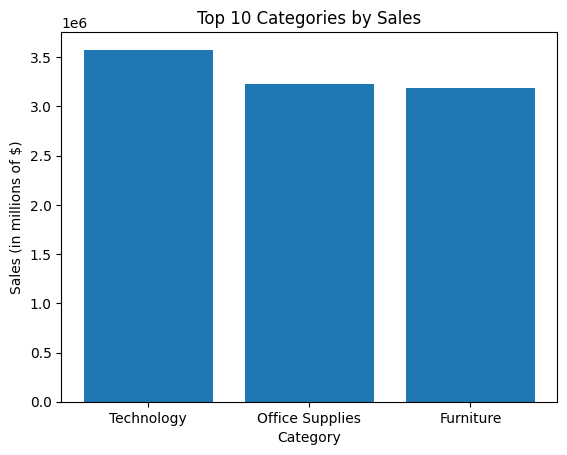

In [158]:
# Selecting only the 'category' and 'sales' columns
selected_columns = df[['category', 'sales']]

# Group by 'category' and sum up the 'sales' for each category
category_sales = selected_columns.groupby('category')['sales'].sum().reset_index().sort_values(by='sales', ascending=False)

# Select the top 10 rows
top_10_categories = category_sales.head(10)

plt.bar(top_10_categories['category'], top_10_categories['sales'])
plt.xlabel('Category')
plt.ylabel('Sales (in millions of $)')
plt.title('Top 10 Categories by Sales')

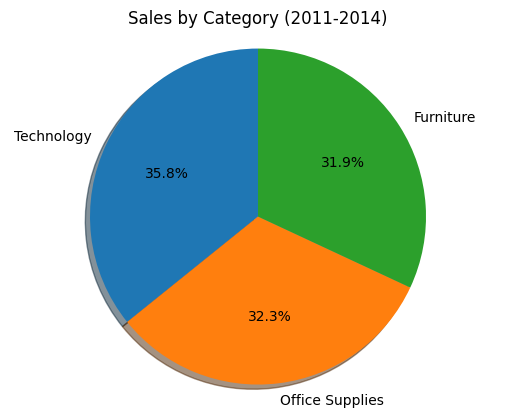

In [157]:
#because there are only three categories, it may be a better visualization to use pie chart 
labels = category_sales['category']
sizes = category_sales['sales']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 

plt.title("Sales by Category (2011-2014)")
plt.show()

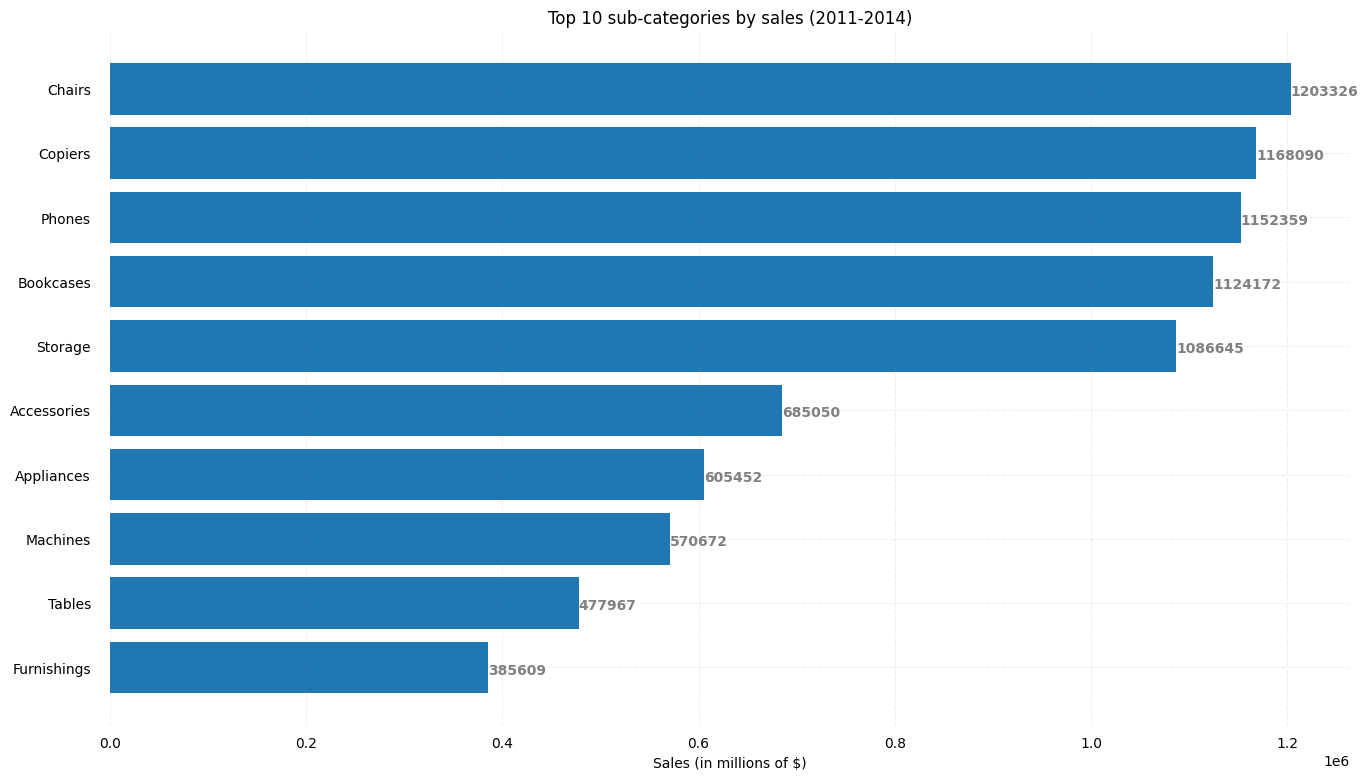

In [159]:
#plt.bar(top_10_subcategories['sub_category'], top_10_subcategories['sales'])
name = top_10_subcategories['sub_category']
sales = top_10_subcategories['sales'].astype(int)
 
# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))
 
# Horizontal Bar Plot
ax.barh(name, sales)
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid (color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values 
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5, 
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
 
# Add Plot Title
ax.set_title('Top 10 sub-categories by sales (2011-2014)',
             loc ='center', )

ax.set_xlabel('Sales (in millions of $)')
 
 
# Show Plot
plt.show()

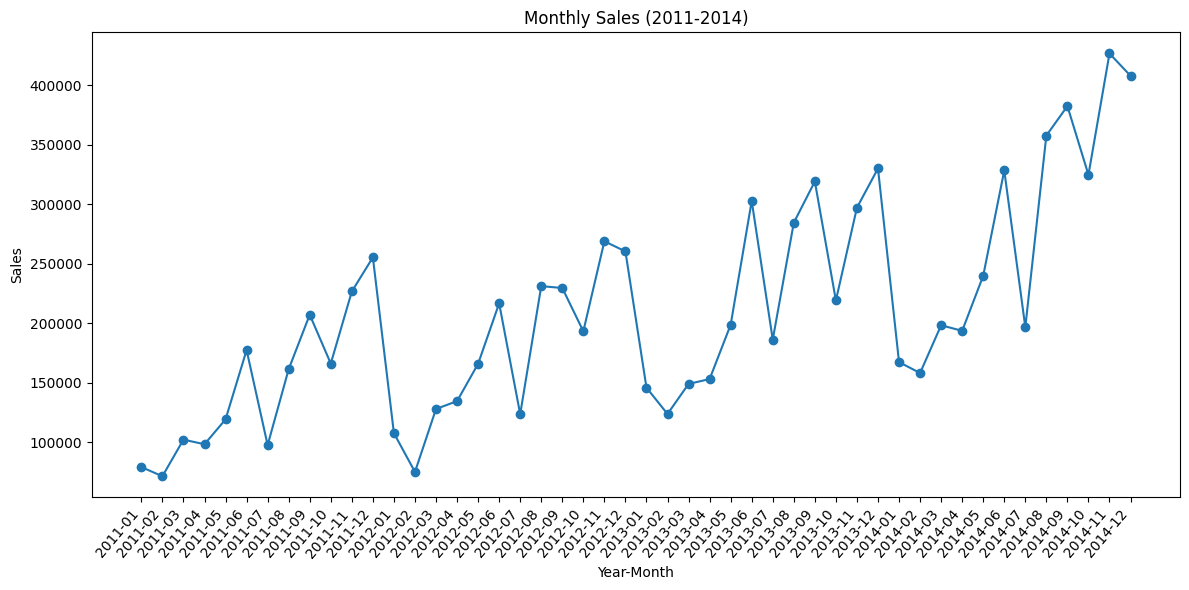

In [160]:
# Convert the 'YearMonth' column to a string
monthly_sales['Year-Month'] = monthly_sales['Year-Month'].astype(str)

# Plotting the line chart
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['Year-Month'], monthly_sales['sales'], marker='o', linestyle='-')

# Adding labels and title
plt.xlabel('Year-Month')
plt.ylabel('Sales')
plt.title('Monthly Sales (2011-2014)')

# Rotating x-axis labels for better readability
plt.xticks(rotation=50, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

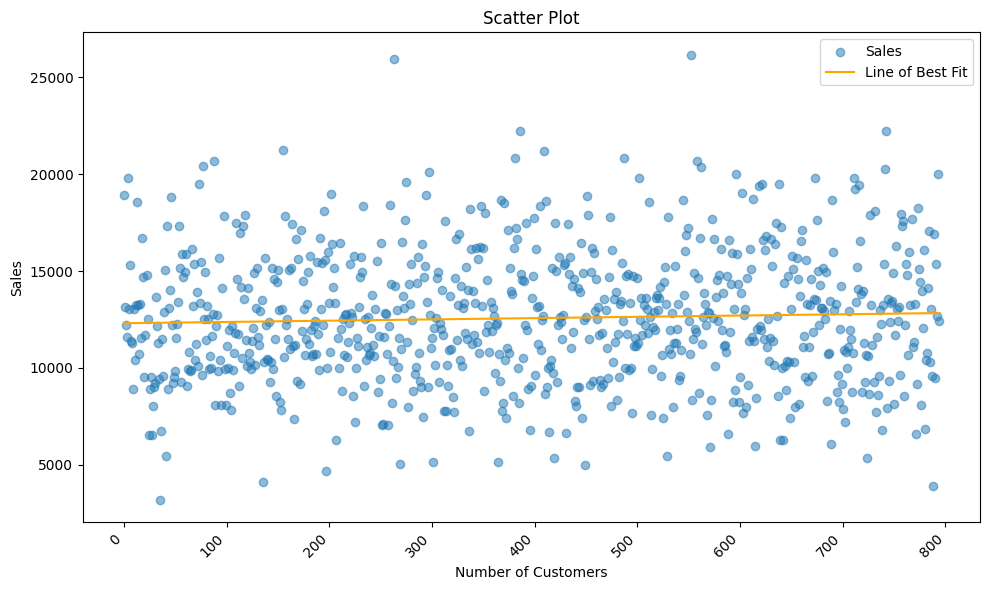

In [161]:
# Create a copy of the DataFrame to avoid modifying the original data
df_encoded = df.copy()

# Use LabelEncoder to convert 'customer_name' to numeric labels
le = LabelEncoder()
df_encoded['customer_label'] = le.fit_transform(df['customer_name'])

# Group by 'customer_label' and calculate the sum of 'sales' for each customer
customer_sales = df_encoded.groupby('customer_label')['sales'].sum()

# Plotting the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(customer_sales.index, customer_sales.values, alpha=0.5, label='Sales')

# Fit a linear regression model
lr = LinearRegression()
X = customer_sales.index.values.reshape(-1, 1)
y = customer_sales.values.reshape(-1, 1)
lr.fit(X, y)

# Plot the regression line
plt.plot(X, lr.predict(X), color='orange', label='Line of Best Fit')

plt.xlabel('Number of Customers')
plt.ylabel('Sales')
plt.title('Scatter Plot')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()